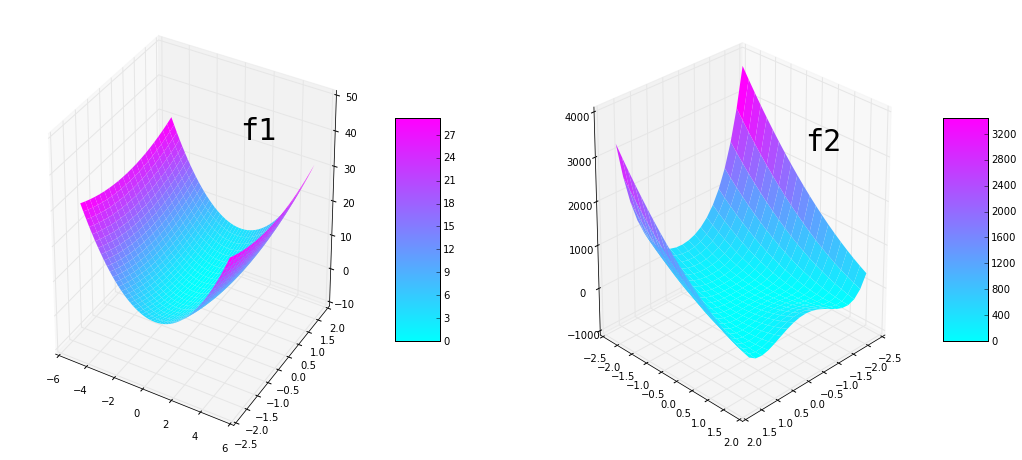

In [12]:
%matplotlib inline
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm, ticker
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import matplotlib.pyplot as plt
from IPython.html.widgets import interact, interactive, fixed
from IPython.html import widgets
import numpy as np
from numpy.random import random
plt.rcParams['figure.figsize'] = (18, 8)

fig = plt.figure()

# second
ax = fig.add_subplot(1,2,2,projection='3d')
X = np.arange(-2.047, 2.048, 0.20)
Y = np.arange(-2.047, 2.048, 0.20)
X2, Y2 = np.meshgrid(X, Y)
Z2 = 100*(X2**2 - Y2)**2 + (1-X2)**2
surf2 = ax.plot_surface(X2, Y2, Z2, rstride=1, cstride=1, cmap=cm.cool, 
                       linewidth=0, antialiased=True)
ax.set_zlim(-1000, 4000)
fig.colorbar(surf2, shrink=0.5, aspect=5)
ax.view_init(elev=25, azim=45)
ax.text(0,2,4000,'f2',fontsize=30,fontname='monospace')



# first
ax = fig.add_subplot(1,2,1,projection='3d')
X = np.arange(-5.11, 5.12, 0.20)
Y = np.arange(-2.047, 2.048, 0.20)
X1, Y1 = np.meshgrid(X, Y)
Z1 = X1**2+Y1**2
surf1 = ax.plot_surface(X1, Y1, Z1, rstride=1, cstride=1, cmap=cm.cool, 
                       linewidth=0, antialiased=True)
ax.set_zlim(-10, 50)
ax.text(0,2,30,'f1',fontsize=30,fontname='monospace')
fig.colorbar(surf1, shrink=0.5, aspect=5)



/usr/local/lib/python3.4/site-packages/matplotlib/contour.py:1516: UserWarning: Log scale: values of z <= 0 have been masked
  warnings.warn('Log scale: values of z <= 0 have been masked')


<a list of 5 text.Text objects>

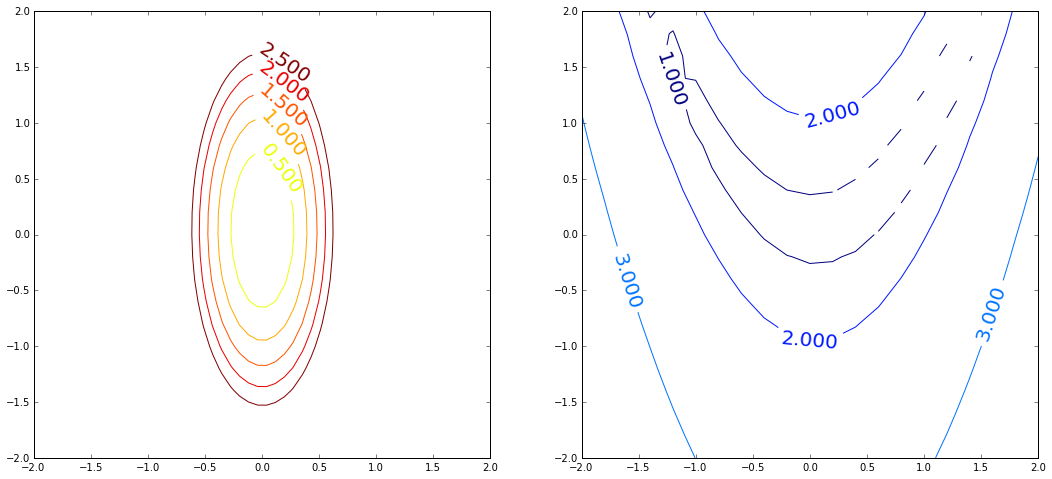

In [13]:
levels = np.arange(-3,3,0.5)
plt.subplot(1,2,1)
CR1 = plt.contour(Z1,levels, extent=[-2,2,-2,2])
plt.clabel(CR1,fontsize=20)
#plt.contour(X1,Y1,Z1)
plt.subplot(1,2,2)
levels = np.arange(-100,100,1)
CR2 = plt.contour(np.log10(Z2),levels,locator=ticker.LogLocator(),extent=[-2,2,-2,2])
plt.clabel(CR2,fontsize=20)

## Test functions

$$f_1(x_1,x_2,x_3)=\sum_{i=1}^3 x_i^2, 5.11 \leq x_i \leq 5.12$$

$$f_2(x_1,x_2)=100(x_1^2 - x_2)^2 + (1-x_1)^2, -2.047 \leq x_i  \leq 2.048 $$

In [15]:
def f1(chromosome):
    return sum([chromosome[i]**2 for i in range(len(chromosome))])

def f2(chromosome):
    return 100*(chromosome[0]**2 - chromosome[1])**2 + (1-chromosome[0])**2

def fitness(f,chromosome):
    return f(chromosome)
 

In [16]:
def RV4LimitSpace(dim,r):
    d = int(np.log10(r)+1)*10
    return random(dim)*d % d+1 -r

In [17]:
def randint(a,b):
    b = b - a
    return int(random()*(10**np.log(b))%b) + a 

#### Reconstruction of the phenotype from the genotype site

>$y_{i}=\sigma_{k=1}^{B}b_{ik}2^{-k},    \;\; w_{i}=a[y_{i}]+b$

> where $a$ and $b$ are the scaling and shifting factors.

>cite: Handout Lec06 p.22



In [18]:
class Gene:    
    #-------------------------------------------------------
    # This class has a genotype(M bits binary) and a phenotype (decimal number collesponding the genotype)
    #
    # obj: objective function
    # M : the length of genotype
    # dim : the dimension of the solution space 
    # a : scaling
    # b : shifting
    #-------------------------------------------------------
    
    def __init__(self, obj, M,dim,a,b, genotype=None):
        if genotype is None:
            # generate M-bits binary dim times
            self.obj = obj
            self.genotype = [[int(g[k]%2) for k in range(0,M) for g in [random(M)*10]] for x in range(0,dim)]
            # decode the genotype
            self.phenotype = [sum([g[i]*2**(-i) for i in range(0,len(g))])*a-b for g in self.genotype]
            self.fitness = obj(self.phenotype)
            self.a = a
            self.b = b
        else:
            self.obj = obj
            self.genotype = genotype
            self.phenotype = [sum([g[i]*2**(-i) for i in range(0,len(g))])*a-b for g in self.genotype]
            self.fitness = obj(self.phenotype)
            self.a = a
            self.b = b
    
    def getGenotype(self):
        return self.genotype

    def getPhenotype(self):
        return self.phenotype   
    
    def setFitness(self, phenotype):
        self.fitness = self.obj(self.phenotype)

    def setPhenotype(self,genotype):
        self.phenotype = [sum([g[i]*2**(-i) for i in range(0,len(g))])*self.a-self.b for g in genotype]
        self.setFitness(self.phenotype)
        
    def setGenotype(self,genotype):
        self.genotype = genotype
        self.setPhenotype(self.genotype)
     

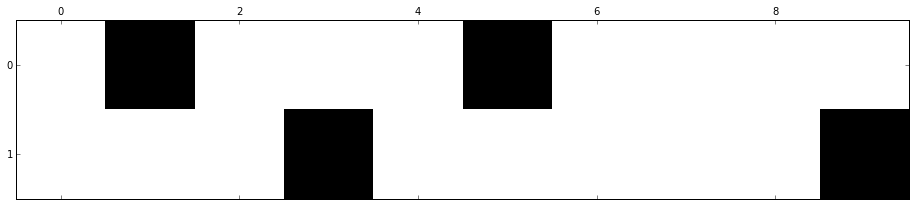

In [23]:
obj= f1
M = 10
dim = 2
a = -5; b = 5
test_gene = Gene(obj,M,dim,a,b)
plt.matshow(test_gene.genotype,cmap=plt.cm.gray)

In [32]:
test_gene.phenotype

[-11.2109375, -13.65234375]

In [ ]:
def mutation(gene,mutation_rate):
    dim = len(gene.genotype)
    def generate_mutation(genotype,pm):
        return [(bit+int(random()>pm))%2 for bit in genotype]    
    gene.setGenotype([generate_mutation(gene.genotype[i],mutation_rate) for i in range(0,dim)])

mutated_gene = mutation(test_gene,0.5)    
plt.matshow(test_gene.genotype,cmap=plt.cm.gray)

In [41]:
def crossover(chromosomes):  
    crossover_point = randint(0,len([chromosomes[0]]))    
    temp = chromosomes[0][crossover_point:]
    chromosomes[0][crossover_point:] = chromosomes[1][crossover_point:]
    chromosomes[1][crossover_point:] = temp
    return chromosomes

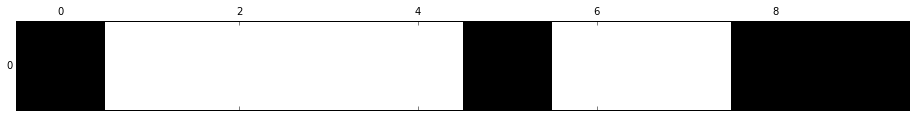

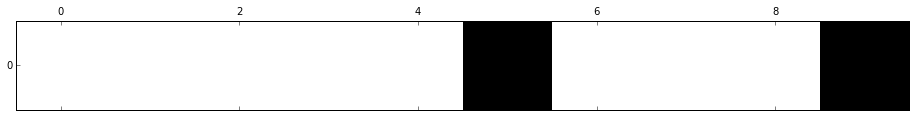

In [35]:
dim = 1
parents = [Gene(obj,M,dim,a,b) for g in range(0,2)] 
[plt.matshow(g.genotype ,cmap=plt.cm.gray) for g in parents] 


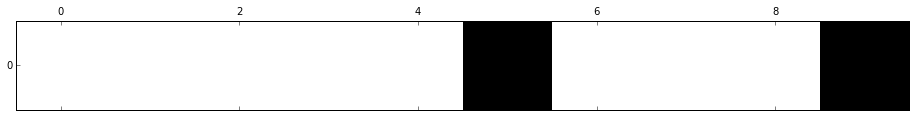

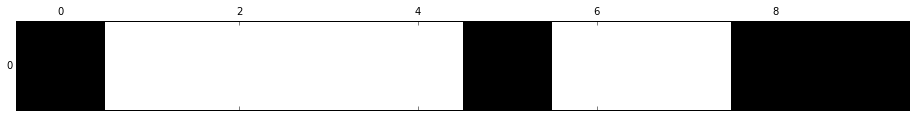

In [51]:
chromosomes = [p.genotype for p in parents]
childs = crossover(chromosomes)
[plt.matshow(c,cmap=plt.cm.gray) for c in childs]

In [48]:
def GA(obj,dim) :
    N = 30 # the number of population
    M = 20 # the lenght of genotype
    sr = 0.7 # selection rate
    a = 2.5
    b = 0
    popSize = int(N*sr) # the number of trucation selection (correspond to selection rate)
    pm = 0.6
    pos_his = []
    val_his = []
    
    def crossover(chromosomes):  
        crossover_point = randint(0,len(chromosomes[0]))    
        temp = chromosomes[0][crossover_point:]
        chromosomes[0][crossover_point:] = chromosomes[1][crossover_point:]
        chromosomes[1][crossover_point:] = temp
        return chromosomes

    def mutation(gene,mutation_rate):
        dim = len(gene.genotype)
        def generate_mutation(genotype,pm):
            return [(bit+int(random()>pm))%2 for bit in genotype]    
        gene.setGenotype([generate_mutation(gene.genotype[i],mutation_rate) for i in range(0,dim)])

    
    #---- Step 1: Generate new solutions -------------------------#
    population = [Gene(obj,M,dim,a,b) for g in range(0,N)]

    #---- Step 3: If the current best solutions is good enough, stop; otherwise return to step1 ----#

    for cnt in range(0,300):
        # Step 3.1 Selection (by tounament)
        new_population = sorted(population, key=lambda population: population.fitness) # sorted by fitness

        solution = new_population[0].phenotype
        val = new_population[0].fitness
        val_his.append(val)
        pos_his.append(solution)


        [new_population.pop(-1) for i in range(0,popSize)] # trunction selection  
       
        # Step 3.2 Reproduction      
        # for each new population
        for i in range(N-popSize,len(population)):
            # select parents randomly             
            parents = [new_population[randint(0,N-popSize)] for i in range(0,2)]
            # produce children genotype by crossover the parents
            children_geno = [crossover([parent.genotype[i] for i in range(0,dim)]) for parent in parents][randint(0,2)]
            new_population.append(Gene(obj,M,dim,a,b,children_geno))     
        [mutation(p,pm) for p in population]
        population = new_population
        
    return solution, val, val_his, pos_his

In [49]:
[solution, val, val_his, pos_his] = GA(f2,2)

0.004203660183483103


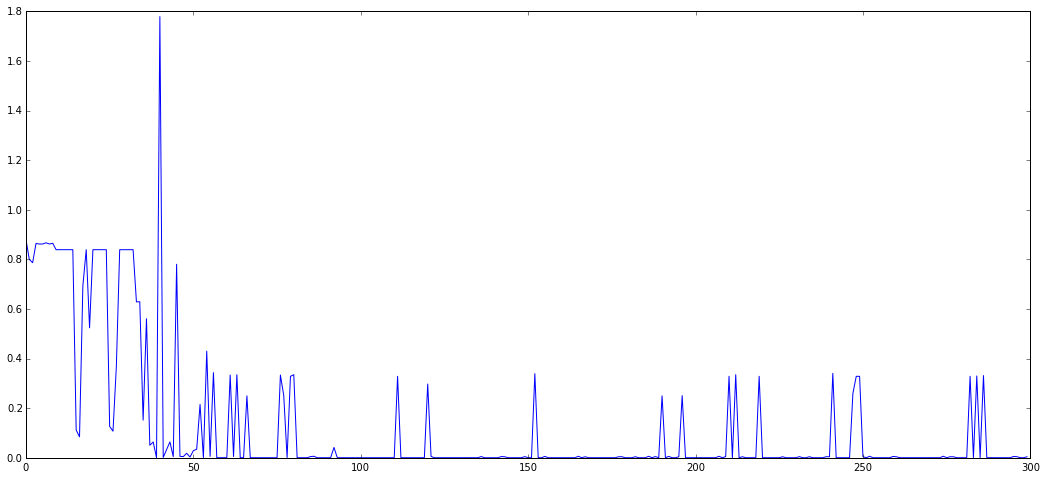

In [50]:
# Show history
plt.plot(val_his)
print(val_his[-1])

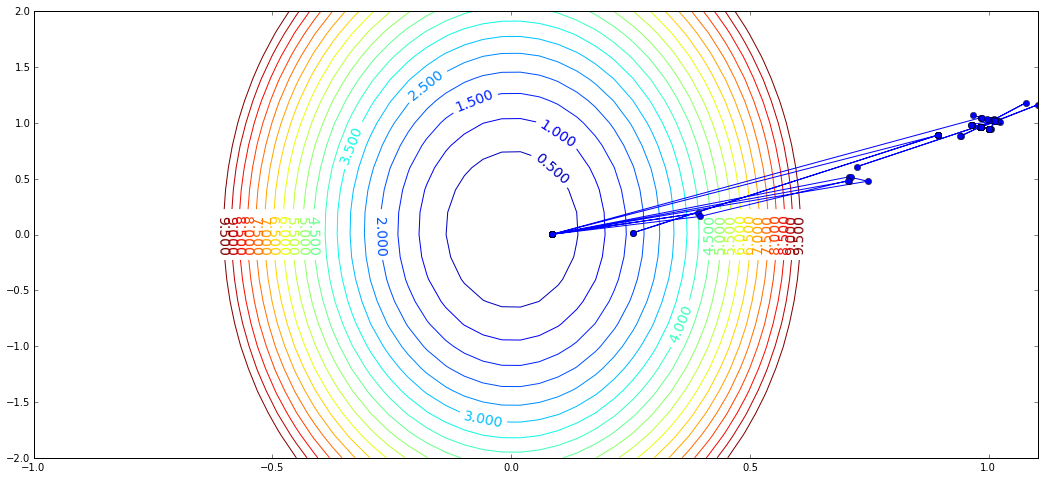

In [51]:
#F1
pos_info = [ p for p in zip(*pos_his)]
levels = np.arange(0,10,0.5)
CR1 = plt.contour(Z1,levels, extent=[-1,1,-2,2])
plt.clabel(CR1,fontsize=14)
pos_x = pos_info[0]
pos_y = pos_info[1]
#plt.plot(pos_x,pos_y)
plt.plot(pos_x,pos_y ,'-o')


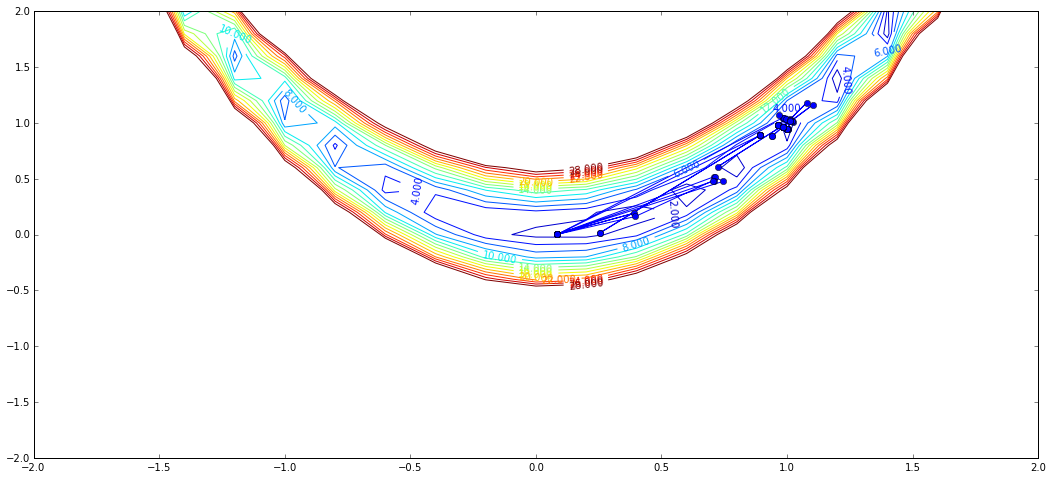

In [52]:
#F2
pos_info = [ p for p in zip(*pos_his)]

levels = np.arange(0,30,2)
CR2 = plt.contour(Z2,levels,extent=[-2,2,-2,2])
plt.clabel(CR2,fontsize=10)

pos_x = pos_info[0]
pos_y = pos_info[1]
plt.plot(pos_x,pos_y, '-o')
#plt.scatter(pos_x,pos_y)

In [53]:
class Agent:
    def __init__(self,obj,vector):
        self.vector = vector
        self.fitness = obj(vector)
    
    def getVector(self):
        return self.vector

    def setVector(self, vector):
        self.vector = vector

In [77]:
def DE(obj,dim) :
    N = 10
    r = 5.11
    w = 1 # differential weight [0,2]
    CR = 0.8 # crossover rate [0.4,1]
    val_his = []
    pos_his = []
    
    def new_agent(obj,agent, population, weight, crossover_rate):
        N = len(population)
        dim = len(agent.vector)      
    
        i_1 = randint(0,N) # FIX: durty code
        i_2 = randint(0,N)
        i_3 = randint(0,N)
    
        while ((i_2 == i_3) or (i_1 == i_2) or (population[i_1] == agent)):
            i_3 = randint(0,N)
            while ((i_1 == i_2) or (population[i_1] == agent)):
                i_2 = randint(0,N)
                while (population[i_1] == agent):
                    i_1 = randint(0,N)
    
        new_vec = [population[i_3].vector[i] + weight*(population[i_1].vector[i]-population[i_2].vector[i]) for i in range(0,dim)]
        new_vec = [new_vec[i] if (random() < crossover_rate) else agent.vector[i]  for i in range(0,dim)]
        new_p = Agent(obj,new_vec)
        return new_p
    
    
    # Step 1. Initialization
    population= [Agent(obj,RV4LimitSpace(dim,r)) for i in range(0,N)]
    
    # Step 2. Get an agent
    # obtain the best fitness agent by sorting and get an head element.
    best_agent = sorted(population, key=lambda population: population.fitness)[0]

    # update information (not essential part)
    val = best_agent.fitness
    val_his.append(val)
    solution = best_agent.vector
    pos_his.append(solution)
        
    for cnt in range(0,300):
        new_population = []

        # Step 3. Perturbation
        candidates = [new_agent(obj,population[0],population, w,CR) for p in population]
   
        # Step 4. Selection
        # select an agent which has higher fitness 
        new_population = [candidates[i] if (population[i].fitness >candidates[i].fitness) else population[i] for i in range(0,N)]       
        
#        print("result--------------")
#        [print(p.fitness) for p in sorted(new_population, key=lambda new_population: new_population.fitness)]

        best_agent = sorted(new_population, key=lambda new_population: new_population.fitness)[0]
        # update information (not essential part)
        val = best_agent.fitness
        val_his.append(val)
        solution = best_agent.vector
        pos_his.append(solution)
        
        population = new_population
        
#        print("sol:", solution, "val:", val)
        
    return solution, val, val_his, pos_his
    

1.21906002762


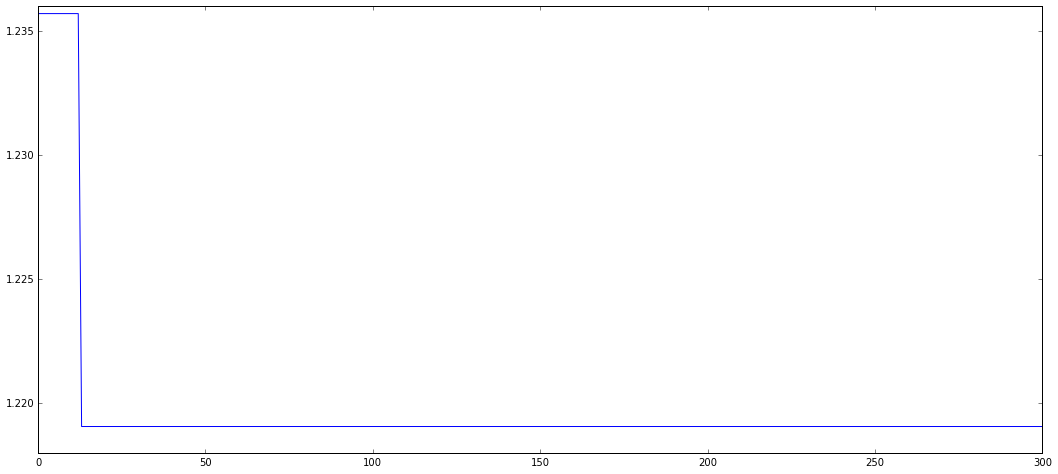

In [84]:
solution, val, val_his, pos_his = DE(f2,3)
print(val)
plt.plot(val_his)

0.0157322823607


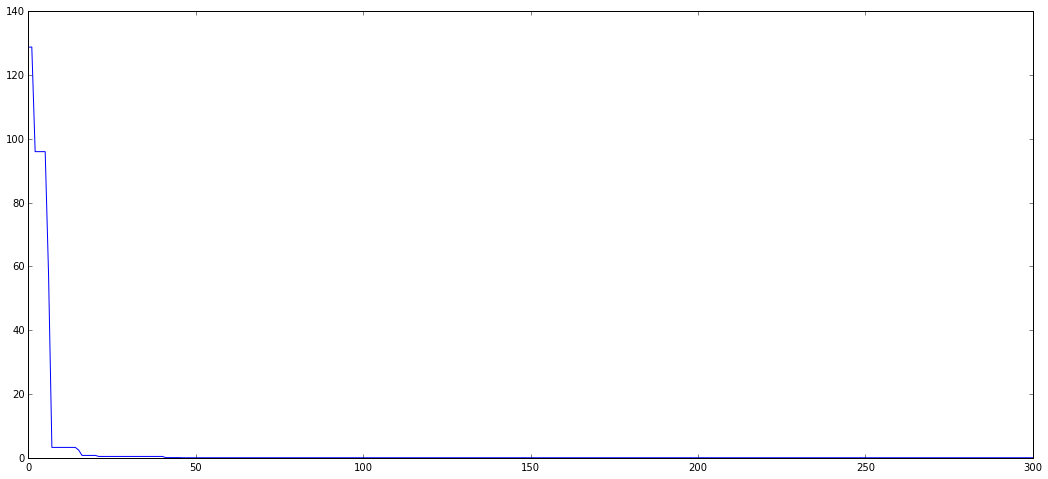

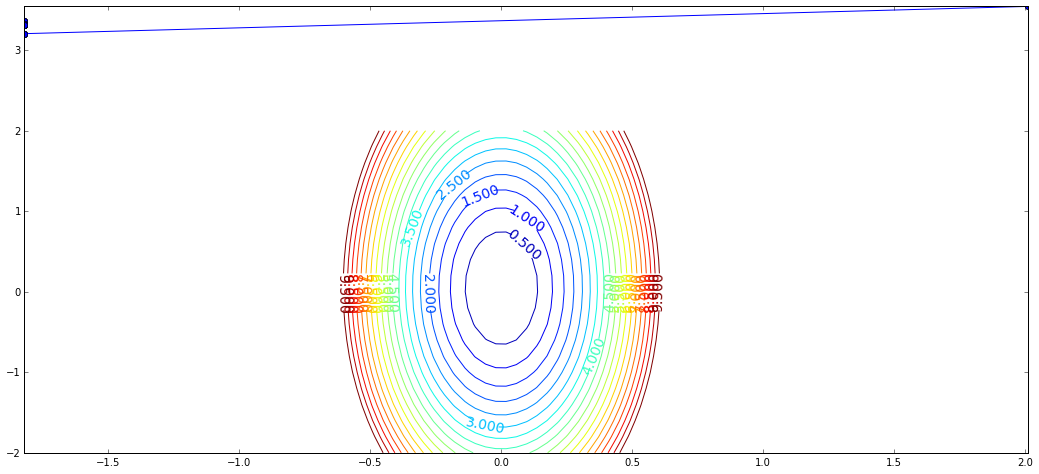

In [69]:
#F1
pos_info = [ p for p in zip(*pos_his)]
levels = np.arange(0,10,0.5)
CR1 = plt.contour(Z1,levels, extent=[-1,1,-2,2])
plt.clabel(CR1,fontsize=14)
pos_x = pos_info[0]
pos_y = pos_info[1]
#plt.plot(pos_x,pos_y)
plt.plot(pos_x,pos_y ,'-o')


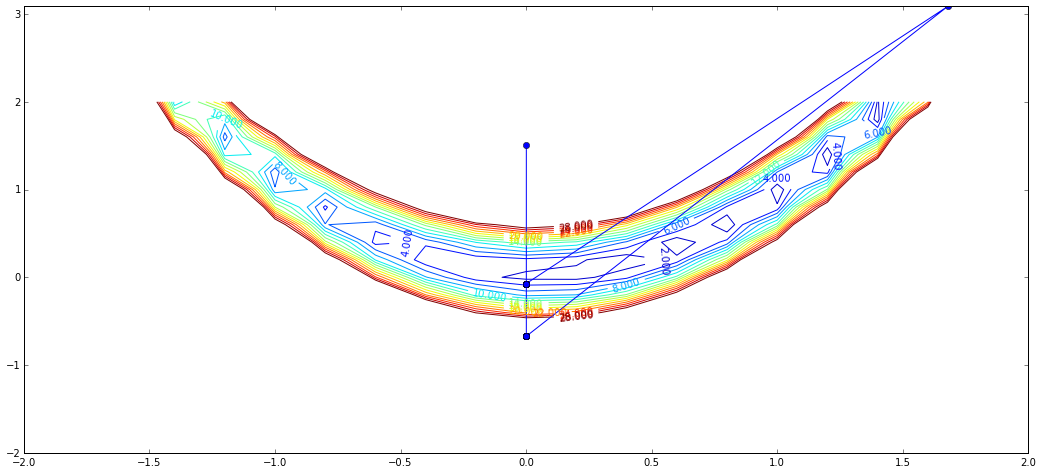

In [1425]:
#F2
pos_info = [ p for p in zip(*pos_his)]

levels = np.arange(0,30,2)
CR2 = plt.contour(Z2,levels,extent=[-2,2,-2,2])
plt.clabel(CR2,fontsize=10)

pos_x = pos_info[0]
pos_y = pos_info[1]
plt.plot(pos_x,pos_y, '-o')
#plt.scatter(pos_x,pos_y)

In [89]:
class Particle:
    def __init__(self, position, velocity):
        self.position = position
        self.velocity = velocity
        self.fitness = 0.0
    
    def getPosition(self):
        return self.position

    def getVelocity(self):
        return self.velocity

    def setPosition(self, position):
        self.position = position

    def setVelocity(self,velocity):
        self.velocity = velocity

In [16]:
dim = 2
r = 5.11
N = 3
a = 0.05 # inertia weight
b = 0.9 # the learning factor (personal influence)
c = 0.5 # the learning factor (social finfluence)
p_best = [0.8, 1.8]
g_best = [0.7,1.7]
swarm = [Particle(RV4LimitSpace(dim,r) ,random(dim)*10) for i in range(0,N)]
new_velocities = [a*s.velocity + b*random()*(p_best - s.position) + c*random()*(g_best - s.position)  for s in swarm]
new_positions = [ s.position + v  for (s,v) in zip(swarm, new_velocities)]

#print('swarmpos:',swarm,'velo:', new_velocities,'pos:', len(new_positions))

In [116]:
def PSO(obj,dim):

    def UpdateParticles(swarm, p_best, g_best):
        a = 0.01 # inertia weight
        b = 0.01 # the learning factor (personal influence)
        c = 0.01 # the learning factor (social finfluence)        

        positions = [s.position for s in swarm]    
        new_velocities = [a*s.velocity + b*random()*(p_best - s.position) + c*random()*(g_best - s.position)  for s in swarm]
        new_positions = [ s.position + v  for (s,v) in zip(swarm, new_velocities)]
        new_swarm = [Particle(new_positions[i], new_velocities[i]) for i in range(0,len(swarm))]
        return new_swarm

    swarm = []  # empty set
    N = 50 # The number of swarm
    g_best = []
    
    g_history = []
    pos_history = []

    # Set the space of finding
    if obj == f1:
        r = 5.11
    elif obj == f2:
        r = 2.048
    else : 
        r = 10
    
    # Step 1: Randomly initialize te swarm
    swarm = [Particle(RV4LimitSpace(dim,r) ,random(dim)*10) for i in range(0,N)]

    # Step 2: Evaluate all particles
    fit_val = [f1(s.position) for s in swarm]
    p_best =  swarm[fit_val.index(min(fit_val))].position 
    g_best = p_best
    
    cnt = 0
    # Step 3: For each particles
    while(obj(g_best)>1e-3):
        cnt += 1
        if cnt > 300 :
            print('Could not find')
            return g_best, obj(g_best), g_history, pos_history
            #break
            
        # Update particles
        swarm = UpdateParticles(swarm, p_best, g_best)      
        
        # Evaluate the particle
        fit_val = [f1(s.position) for s in swarm]        
        p_best = swarm[fit_val.index(min(fit_val))].position
        
    # Step 4: Update if necessary the leader of the swarm and the best position obtained by each particles        
        if (obj(g_best) < obj(p_best)):
            g_best = g_best
        else :
            g_best = p_best
#        g_best = (g_best if (obj(g_best)<obj(p_best)) else p_best)
        
        g_history.append(obj(g_best))
        pos_history.append(g_best)
    # Step 5: Stop if terminating condition satisfied; return to Step 3 otherwise          
    return g_best, obj(g_best), g_history, pos_history
    

Could not find
[ 0.12943581 -0.07042822  0.02157285] 0.0221791515304


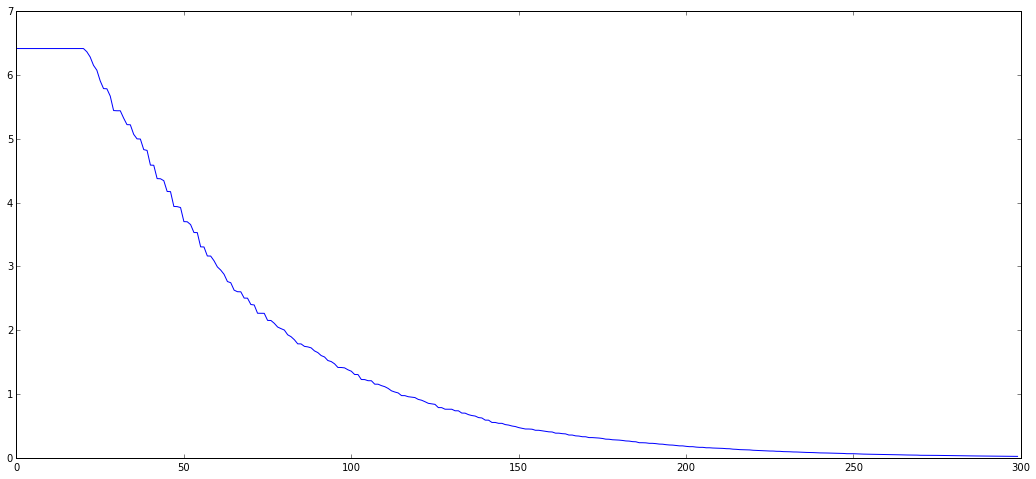

In [117]:
[solution, val, val_his, pos_his] = PSO(f1,3)
print(solution, val)
plt.plot(val_his)

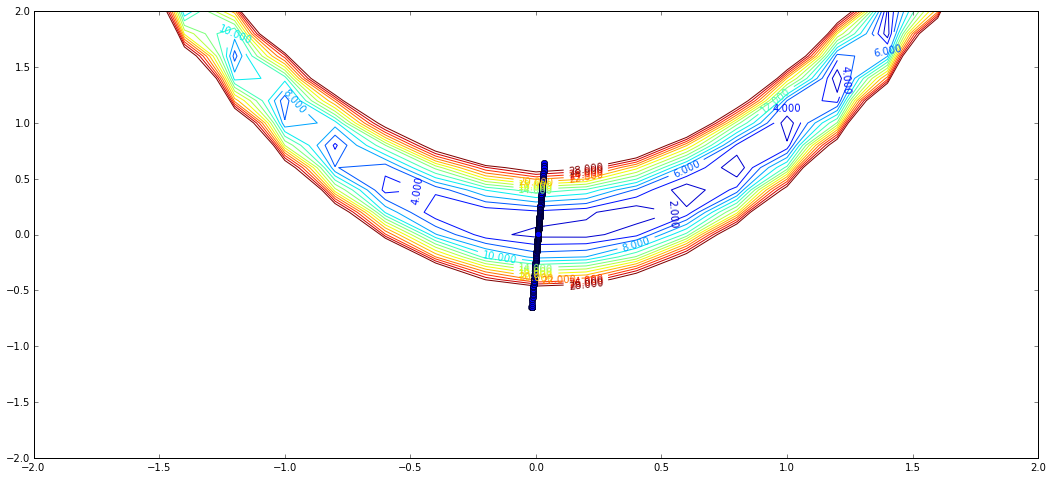

In [1185]:
#F1
pos_info = [ p for p in zip(*pos_his)]

levels = np.arange(0,30,2)
CR2 = plt.contour(Z2,levels,extent=[-2,2,-2,2])
plt.clabel(CR2,fontsize=10)

pos_x = pos_info[0]
pos_y = pos_info[1]
plt.plot(pos_x,pos_y, '-o')
#plt.scatter(pos_x,pos_y)

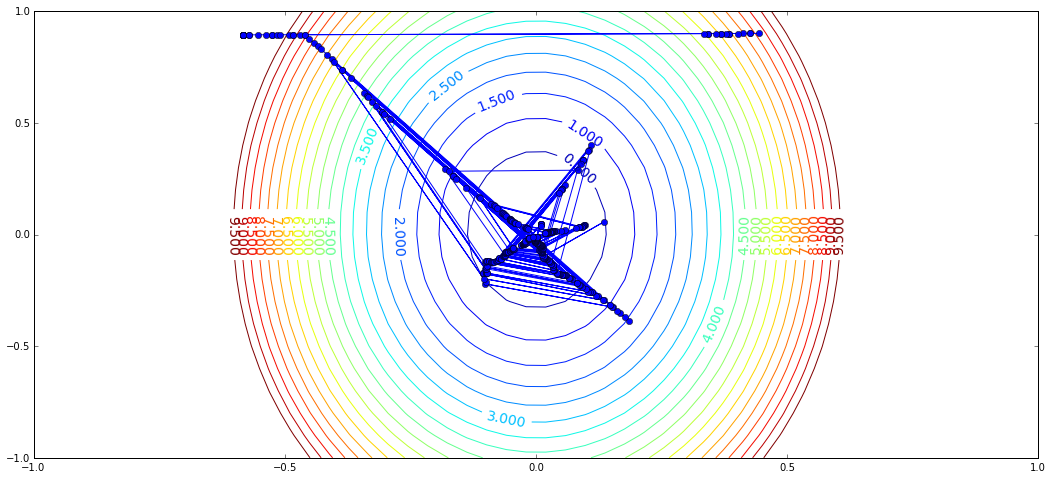

In [1168]:
#F2
pos_info = [ p for p in zip(*pos_his)]
levels = np.arange(0,10,0.5)
CR1 = plt.contour(Z1,levels, extent=[-1,1,-1,1])
plt.clabel(CR1,fontsize=14)
pos_x = pos_info[0]
pos_y = pos_info[1]
#plt.plot(pos_x,pos_y)
plt.plot(pos_x,pos_y, '-o')


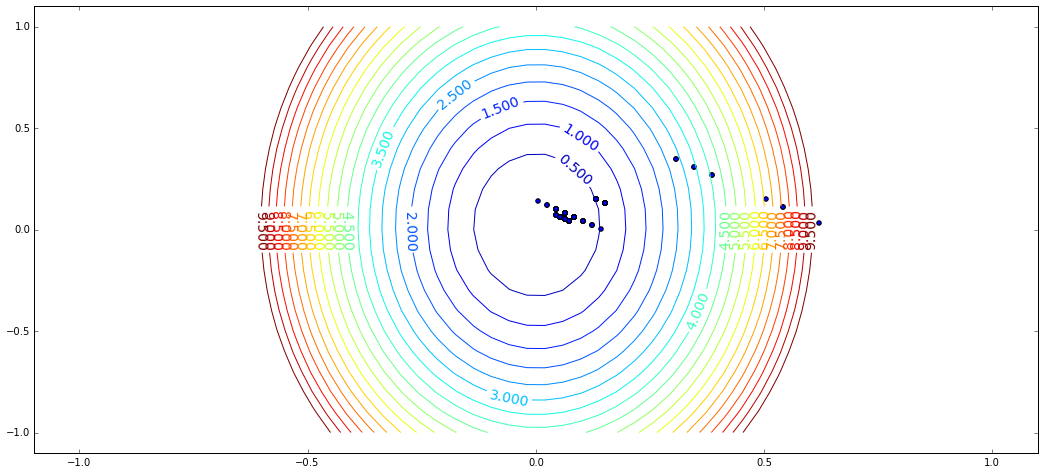

In [1123]:
#F2
pos_info = [ p for p in zip(*pos_his)]
levels = np.arange(0,10,0.5)
CR1 = plt.contour(Z1,levels, extent=[-1,1,-1,1])
plt.clabel(CR1,fontsize=14)
pos_x = pos_info[0]
pos_y = pos_info[1]
#plt.plot(pos_x,pos_y)
plt.scatter(pos_x,pos_y)


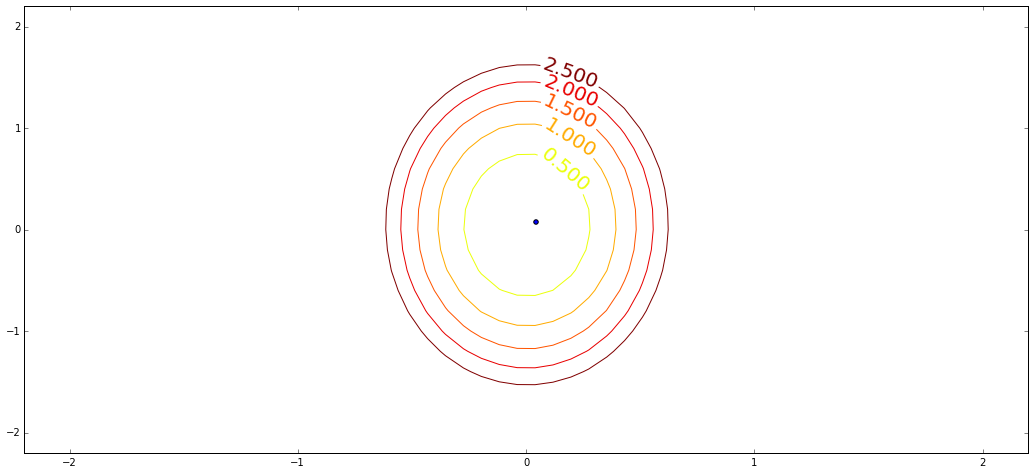

In [1122]:
from IPython.html.widgets import interact

levels = np.arange(-3,3,0.5)


pos_x = pos_info[0]
pos_y = pos_info[1]

def plot_F1history(cnt=0):
    CR1 = plt.contour(Z1,levels, extent=[-2,2,-2,2])
    plt.clabel(CR1,fontsize=20)
    plt.scatter(pos_x[int(cnt*5)],pos_y[int(cnt*5)])
    
    
interact(plot_F1history, cnt=(0,(len(pos_x)/5)-1,1))



> - Step 1: Initialize s and T

> - Step 2: Findasolution s’ in N(s) at random

>> - If $fitness(s’)>fitness(s): s=s’$
>> - Else $s=s'$ with probability $p(s'|T)$

> - Step 3: If not equilibrium state, Step 2; else, update T;

> - Step 4: If terminating condition satisfied,stop.